<a href="https://colab.research.google.com/github/benmanjackson/CS290/blob/main/Penguin_Kmeans_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 11/15/24 Homework

## Task



* implement the k-means clustering algorithm and apply it to either the iris dataset or the penguins dataset (CHECK)
* Allow for two centroid initialization options: either specify the initial centroids or select them randomly from the dataset being used. Experiment with both options to see how the final centroids depend on the initialization.
* When applying your algorithm, plot the data and the current centroids at each iteration. This provides a nice visualization of the algorithm in action. (CHECK)
* With both the iris and penguins datasets, you actually have labels and therefore know the correct number of clusters, k. Experiment with different values of k to see what happens, since the “correct” value isn’t actually known in practice. (Is Possible!)
* a method for calculating accuracy if the true clusters are known (as they are for the iris and penguins datasets) (Check)
* a method for calculating inertia (Check)
* a method for initializing centroids as in Arthur and Vassilvitskii (kmeans++)
* methods for calculating and visualizing silhouette coefficients


[Palmer penguins dataset](https://allisonhorst.github.io/palmerpenguins/).


## Load and inspect the data

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("https://github.com/benmanjackson/CS290/raw/refs/heads/main/penguins.csv")

In [ ]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [ ]:
print(df.columns)

Index(['species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex', 'year'],
      dtype='object')


# Calculate the ***prior probabilities***

In [ ]:
priors = df["species"].value_counts( normalize=True )
priors

,proportion
species,
Adelie,0.441860
Gentoo,0.360465
Chinstrap,0.197674


According to this dataset,
* 44.2% of penguins are Adélie penguins,
* 36% of penguins are Gentoo penguins, and
* 19.8% of penguins are Chinstrap penguins.

One of our key assumptions is that this dataset is ***representative***, i.e., that these proportions accurately reflect the percentages of these different species.


# Get Imports, manage DataFrame and create our functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FixedLocator, FixedFormatter
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples, confusion_matrix

In [ ]:
#Drops rows with missing values
df.dropna(inplace=True)
#We need to encode our categorical target variable (species) into 0,1,2 respectively for the 3 species so that k-means works properly
label_encoder = LabelEncoder()
df['species'] = label_encoder.fit_transform(df['species'])

In [ ]:
features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
X = df[features].values
y = df['species'].values #Gives the true labels for evaluation
df = df.drop(columns=['species'], errors='ignore')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))

In [ ]:
# This is our inertia function, the sum of squared distances of samples to their closest cluster center
def calculate_inertia(X, centroids, clusters):
    distances = np.array([np.array([euclidean_distance(x, centroid) for x in X]) for centroid in centroids])
    return np.sum(np.min(distances, axis=0))

In [ ]:
# Accuracy (if true labels are available)
def calculate_accuracy(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    return np.sum(np.amax(cm, axis=0)) / np.sum(cm)

In [ ]:
#This function is used to initialize our centroids for k-means clustering
def initialize_centroids(X, k, method="random"):
    if method == "random":
      #This will randomly select k datapoints for our initial centroids
        indices = np.random.choice(X.shape[0], size=k, replace=False)
        return X[indices]
    elif method == "kmeans++":
      #K-means++ initialization as described by Arthur and Vassilvitskii
        centroids = [X[np.random.randint(X.shape[0])]] #begins with a random centroid
        for _ in range(1, k):
          #Computes euclidean distance of each point with closest centroid
            distances = np.array([np.min([euclidean_distance(x, centroid) for centroid in centroids]) for x in X])
            #This is the probability proportional to the distance squared
            probs = distances**2 / np.sum(distances**2)
            new_centroid = X[np.random.choice(range(X.shape[0]), p=probs)]
            centroids.append(new_centroid)
        return np.array(centroids)
    else:
        raise ValueError("Invalid method specified for centroid initialization. Maybe try 'random' or 'k-means++'.")

In [ ]:
#This function will assign each data point with their nearest centroid.
def assign_clusters(X, centroids):
  #computes distances from each point to each centroid
    distances = np.array([[euclidean_distance(x, centroid) for centroid in centroids] for x in X])
    #Returns index of closest centroid for each point
    return np.argmin(distances, axis=1)

In [ ]:
#This will be our updating centroids function, which updates centroids via the mean of the points in each cluster
#NEEDS WORK
def update_centroids(X, clusters, k):
    new_centroids = np.zeros((k, X.shape[1]))  # Initialize centroids with zeros
    for j in range(k):
        #Select the points that belong to cluster j
        cluster_points = X[clusters == j]

        #DEBUGGING: Check the shape of cluster_points and clusters
        print(f"Cluster {j}: Number of points = {len(cluster_points)}")
        print(f"Shape of cluster_points: {cluster_points.shape}")
        print(f"Shape of clusters array: {clusters.shape}")

        #If a cluster has no points assigned, lets pick a random point as the centroid
        if cluster_points.shape[0] > 0:
            new_centroids[j] = cluster_points.mean(axis=0)  #Mean across rows
        else:
            #If no points are assigned, just pick the old centroid
            new_centroids[j] = X[np.random.choice(X.shape[0])]

    return new_centroids

In [ ]:
#This function will plot our clusters, allowing us to visualize the current state of the data
def plot_clusters(X, clusters, centroids, iteration):
  plt.figure(figsize=(10, 6))
  for i in range(len(centroids)):
    #Plot the points in each cluster
    plt.scatter(X[clusters == i, 0], X[clusters == i, 1], label=f"Cluster {i+1}")
  #Now plot the centroids
  plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', label="Centroids")
  plt.title(f"Iteration {iteration}")
  plt.legend()
  plt.show()

In [ ]:
def plot_elbow_graph(inertia_values):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(inertia_values) + 1), inertia_values, marker='o', linestyle='-')
    plt.xlabel('Iteration')
    plt.ylabel('Inertia')
    plt.title('Elbow Graph (Inertia per Iteration)')
    plt.grid()
    plt.show()

In [ ]:
#Based off code from 09_Unsupervised_Learning
def plot_silhouette_diagrams(X, kmeans_result, k_values):
  plt.figure(figsize=(11, 9))

  for idx, k in enumerate(k_values, start=1):
      plt.subplot(2, 2, idx)

      # Extract predictions for current k
      y_pred = kmeans_results[k].labels_
      silhouette_coefficients = silhouette_samples(X, y_pred)

      # Initialize variables for plotting
      padding = len(X) // 30
      pos = padding
      ticks = []

      # Plot silhouette coefficients for each cluster
      for i in range(k):
          coeffs = silhouette_coefficients[y_pred == i]
          coeffs.sort()

          color = mpl.cm.Spectral(i / k)
          plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                              facecolor=color, edgecolor=color, alpha=0.7)
          ticks.append(pos + len(coeffs) // 2)
          pos += len(coeffs) + padding

        # Adjust y-axis ticks and labels
      plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
      plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
      if idx in (1, 3):
          plt.ylabel("Cluster")

      if idx in (3, 4):
          plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
          plt.xlabel("Silhouette Coefficient")
      else:
          plt.tick_params(labelbottom=False)

        # Mark average silhouette score with a red dashed line
      silhouette_avg = silhouette_score(X, y_pred)
      plt.axvline(x=silhouette_avg, color="red", linestyle="--")
      plt.title("$k={}$".format(k), fontsize=16)

  plt.tight_layout()
  plt.show()

In [ ]:
#Finally, our k-means algorithm, which will perform k-means clustering, given input data
def k_means(X, k, max_iterations=100, tolerance=1e-4, init_method="random", true_labels=None):
  #Initialize the centroids first
    centroids = initialize_centroids(X, k, method=init_method)
    inertia_values = [] #Array for storing inertia for elbow graph
    for i in range(max_iterations):
      #Assign clusters to nearest centroid
      clusters = assign_clusters(X, centroids)
      #Next, update centroids as the mean of the assigned points
      new_centroids = update_centroids(X, clusters, k)
      #Calculate/ the inertia as well
      inertia = calculate_inertia(X, centroids, clusters)
      inertia_values.append(inertia)
      #Calculate silhouette
      silhouette = silhouette_score(X, clusters) if len(set(clusters)) > 1 else float('nan')
      #Then the accuracy for true labels
      accuracy = calculate_accuracy(true_labels, clusters)
      #Print metrics per iterations
      print(f"Iteration {i}:")
      print(f"  Inertia: {inertia:.4f}")
      print(f"  Silhouette Coefficient: {silhouette:.4f}")
      if true_labels is not None:
          print(f"  Accuracy: {accuracy:.4f}")
      #Then, lets plot the progress
      plot_clusters(X, clusters, centroids, iteration=i)
      #Finally, check for convergence, where the centroids don't move very significantly
      diff = np.linalg.norm(centroids - new_centroids)
      print(f"Iteration {i}: Centroid shift = {diff:.4f}")
      if diff < tolerance:
        print(f"Convergence reached.")
        break
      centroids = new_centroids

    plot_elbow_graph(inertia_values) #Plots inertia

    return centroids, clusters, inertia_values

## Evaluation



Cluster 0: Number of points = 114
Shape of cluster_points: (114, 4)
Shape of clusters array: (333,)
Cluster 1: Number of points = 119
Shape of cluster_points: (119, 4)
Shape of clusters array: (333,)
Cluster 2: Number of points = 100
Shape of cluster_points: (100, 4)
Shape of clusters array: (333,)
Iteration 0:
  Inertia: 364.3750
  Silhouette Coefficient: 0.4104
  Accuracy: 0.8498


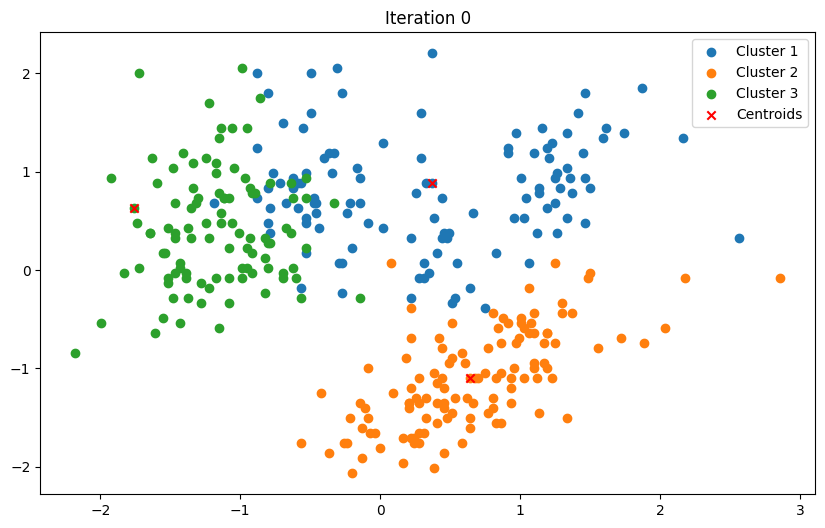

Iteration 0: Centroid shift = 0.7849
Cluster 0: Number of points = 98
Shape of cluster_points: (98, 4)
Shape of clusters array: (333,)
Cluster 1: Number of points = 119
Shape of cluster_points: (119, 4)
Shape of clusters array: (333,)
Cluster 2: Number of points = 116
Shape of cluster_points: (116, 4)
Shape of clusters array: (333,)
Iteration 1:
  Inertia: 329.1889
  Silhouette Coefficient: 0.4331
  Accuracy: 0.8799


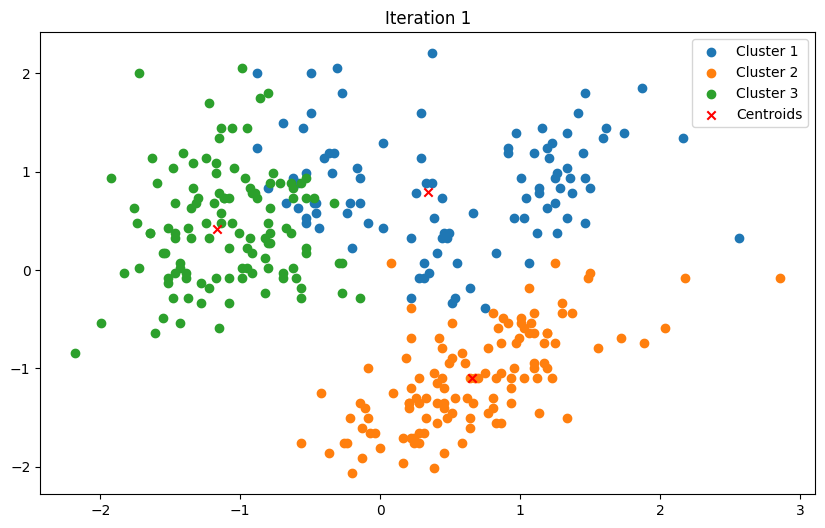

Iteration 1: Centroid shift = 0.2151
Cluster 0: Number of points = 92
Shape of cluster_points: (92, 4)
Shape of clusters array: (333,)
Cluster 1: Number of points = 119
Shape of cluster_points: (119, 4)
Shape of clusters array: (333,)
Cluster 2: Number of points = 122
Shape of cluster_points: (122, 4)
Shape of clusters array: (333,)
Iteration 2:
  Inertia: 326.6251
  Silhouette Coefficient: 0.4413
  Accuracy: 0.8979


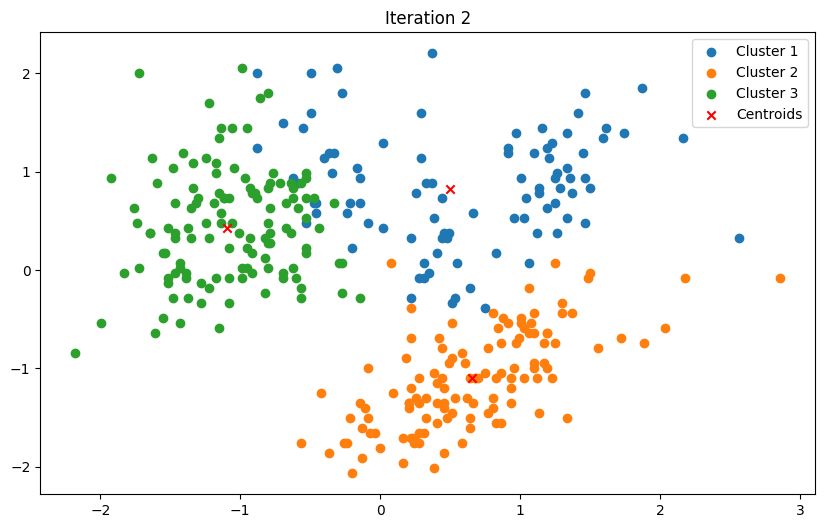

Iteration 2: Centroid shift = 0.0917
Cluster 0: Number of points = 88
Shape of cluster_points: (88, 4)
Shape of clusters array: (333,)
Cluster 1: Number of points = 119
Shape of cluster_points: (119, 4)
Shape of clusters array: (333,)
Cluster 2: Number of points = 126
Shape of cluster_points: (126, 4)
Shape of clusters array: (333,)
Iteration 3:
  Inertia: 325.9596
  Silhouette Coefficient: 0.4438
  Accuracy: 0.9099


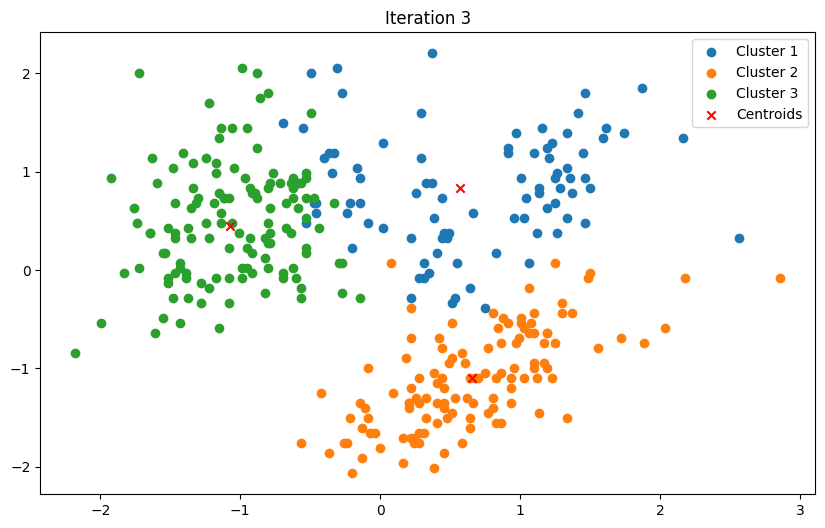

Iteration 3: Centroid shift = 0.0787
Cluster 0: Number of points = 86
Shape of cluster_points: (86, 4)
Shape of clusters array: (333,)
Cluster 1: Number of points = 119
Shape of cluster_points: (119, 4)
Shape of clusters array: (333,)
Cluster 2: Number of points = 128
Shape of cluster_points: (128, 4)
Shape of clusters array: (333,)
Iteration 4:
  Inertia: 325.4830
  Silhouette Coefficient: 0.4455
  Accuracy: 0.9159


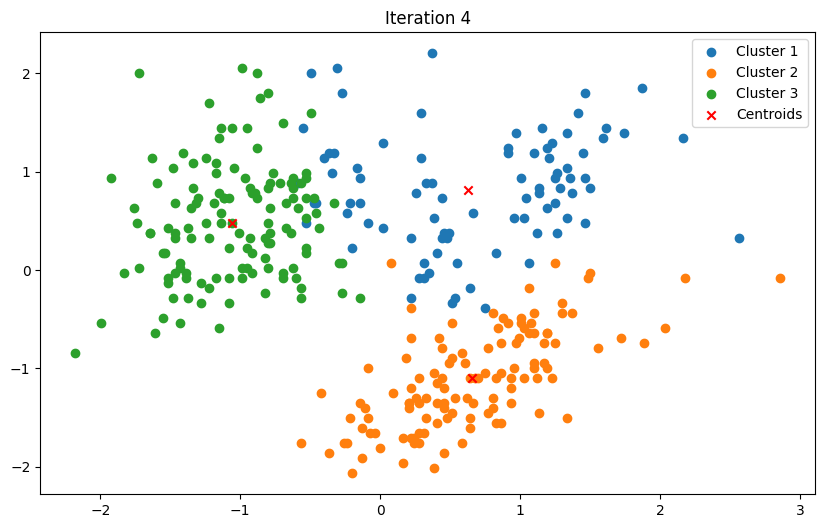

Iteration 4: Centroid shift = 0.0348
Cluster 0: Number of points = 85
Shape of cluster_points: (85, 4)
Shape of clusters array: (333,)
Cluster 1: Number of points = 119
Shape of cluster_points: (119, 4)
Shape of clusters array: (333,)
Cluster 2: Number of points = 129
Shape of cluster_points: (129, 4)
Shape of clusters array: (333,)
Iteration 5:
  Inertia: 325.3644
  Silhouette Coefficient: 0.4462
  Accuracy: 0.9189


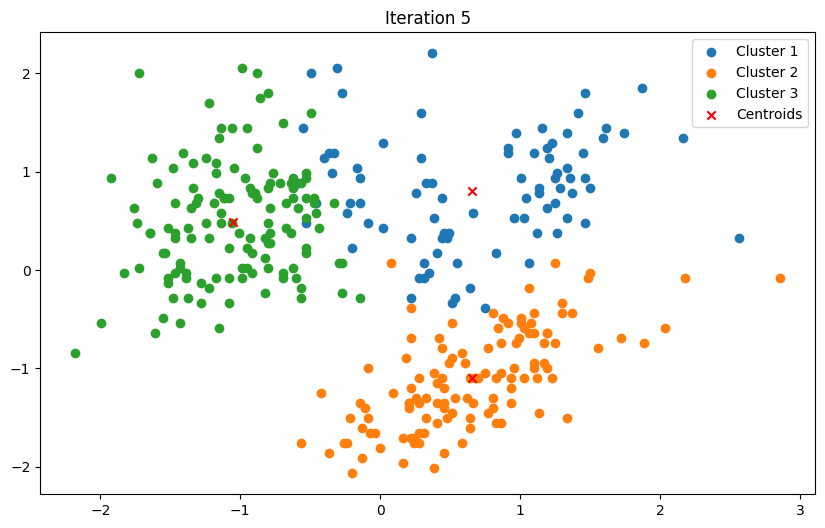

Iteration 5: Centroid shift = 0.0168
Cluster 0: Number of points = 85
Shape of cluster_points: (85, 4)
Shape of clusters array: (333,)
Cluster 1: Number of points = 119
Shape of cluster_points: (119, 4)
Shape of clusters array: (333,)
Cluster 2: Number of points = 129
Shape of cluster_points: (129, 4)
Shape of clusters array: (333,)
Iteration 6:
  Inertia: 325.3256
  Silhouette Coefficient: 0.4462
  Accuracy: 0.9189


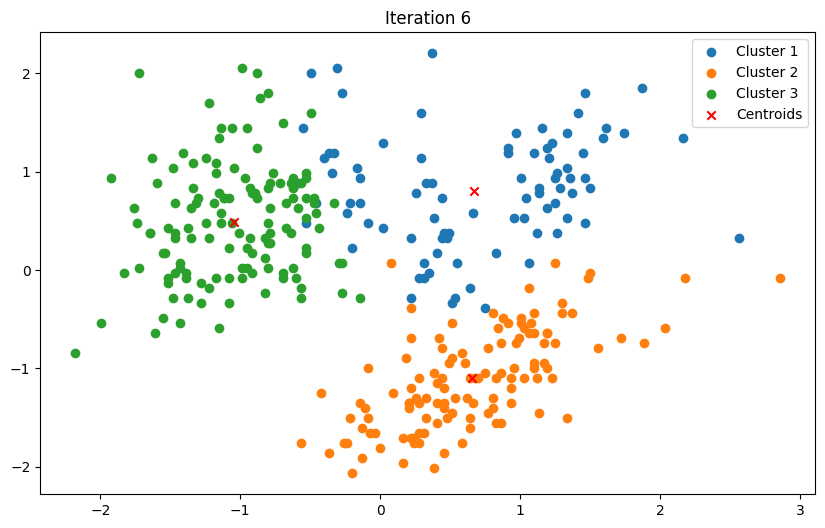

Iteration 6: Centroid shift = 0.0000
Convergence reached.


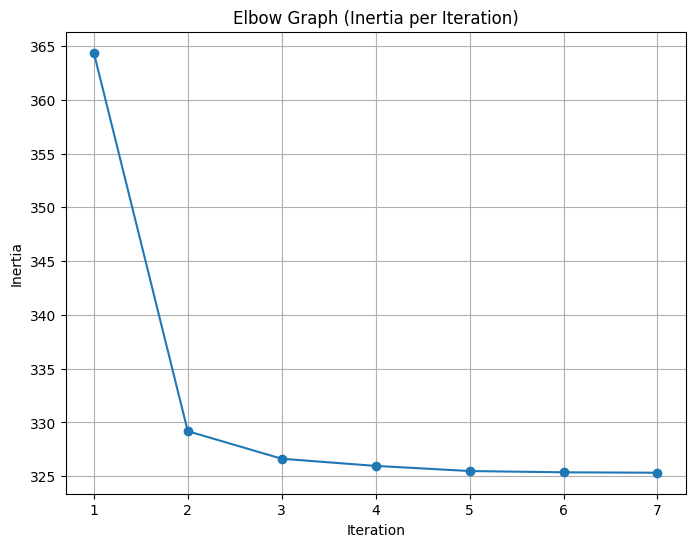

In [ ]:
# Run k-means clustering algorithm! (Set k first though!)
k = 3 # Number of clusters (based on the species in the dataset, we can run it
#without k being equal to species number to simulate not knowing the correct values)
centroids, clusters, inertia_values = k_means(X_scaled, k=k, init_method='kmeans++', true_labels=y)

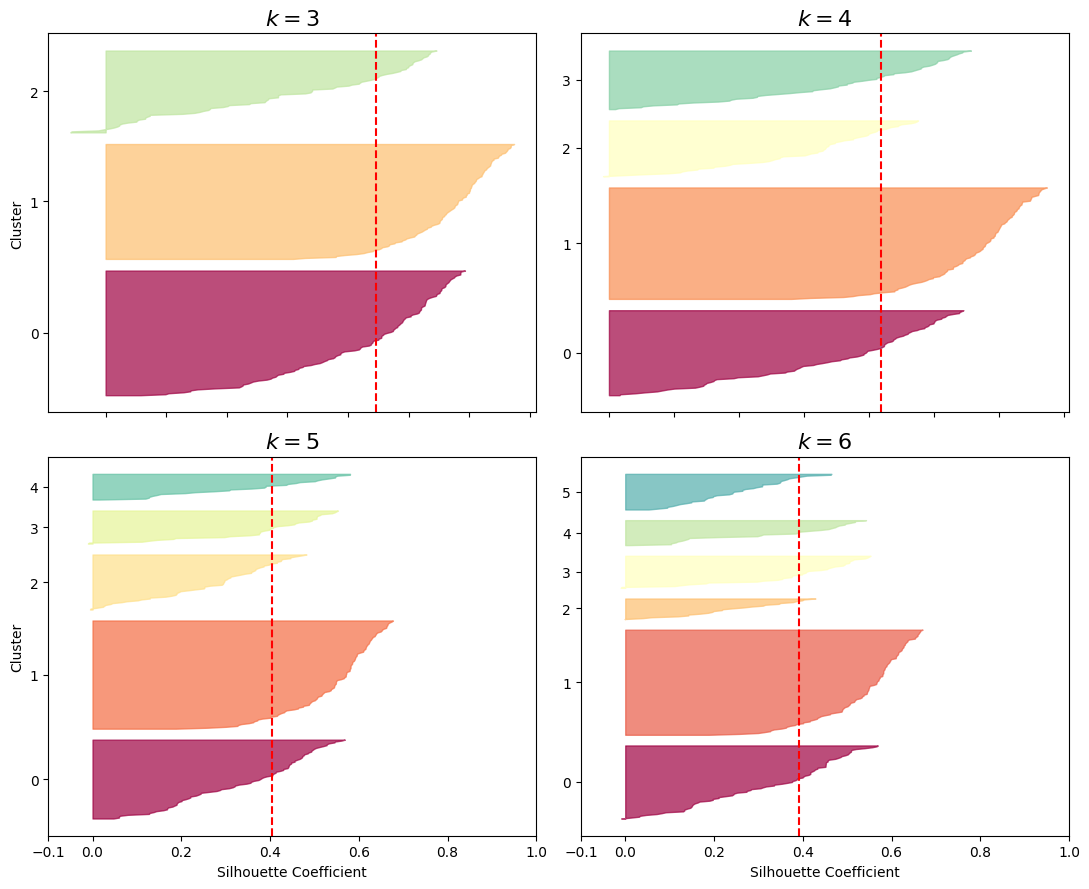

In [ ]:
#Silhouette Analysis Plotting
k_values = [3, 4, 5, 6]
kmeans_results = {}
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    kmeans_results[k] = kmeans

plot_silhouette_diagrams(X_scaled, kmeans_results, k_values)

## Have a great day!